# Predict Handover: LSTM ML

## ETAPA 1 — Pré-processamento da base

### 1.1: Importação de bibliotecas e leitura

In [ ]:
%pip install tensorflow

In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random

In [73]:
# Leitura da base
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/handover_dataset.csv")

# Garantir ordenação temporal por carro
df.sort_values(by=["car", "timestamp"], inplace=True)

# Remover nulos se existirem (opcional)
df.dropna(inplace=True)

# Resetar índices
df.reset_index(drop=True, inplace=True)

In [74]:
print(f"Shape: {df.shape}")
n_handovers = df["handover"].sum()
print(f"Total de handovers: {n_handovers}")

Shape: (610942, 18)
Total de handovers: 125


In [75]:
df.head(10)

,timestamp,car,serving_cell,mac_delay_ul,mac_delay_dl,average_cqi_ul,average_cqi_dl,throughput,handover,pos_x,pos_y,speed,angle,next_serving_cell,delta_x,delta_y,accel,scenario
0,1.100,0,0.0,0.000,0.000,0.0,0.0,36.363636,0,1805.04,2759.39,12.38,204.29,0,0.0,0.0,0.0,A
1,1.100,0,0.0,0.000,0.000,0.0,0.0,36.363636,0,1689.09,3600.05,7.61,42.85,0,0.0,0.0,0.0,C
2,1.105,0,0.0,0.000,0.000,0.0,11.0,0.000000,0,1805.04,2759.39,12.38,204.29,0,0.0,0.0,0.0,A
3,1.105,0,0.0,0.000,0.000,0.0,12.0,0.000000,0,1689.09,3600.05,7.61,42.85,0,0.0,0.0,0.0,C
4,1.109,0,0.0,0.004,0.004,0.0,11.0,0.000000,0,1805.04,2759.39,12.38,204.29,0,0.0,0.0,0.0,A
5,1.109,0,0.0,0.004,0.004,0.0,12.0,0.000000,0,1689.09,3600.05,7.61,42.85,0,0.0,0.0,0.0,C
6,1.120,0,0.0,0.000,0.000,0.0,11.0,71.428571,0,1805.04,2759.39,12.38,204.29,0,0.0,0.0,0.0,A
7,1.120,0,0.0,0.000,0.000,0.0,12.0,71.428571,0,1689.09,3600.05,7.61,42.85,0,0.0,0.0,0.0,C
8,1.124,0,0.0,0.000,0.000,0.0,11.0,0.000000,0,1805.04,2759.39,12.38,204.29,0,0.0,0.0,0.0,A
9,1.124,0,0.0,0.000,0.000,0.0,12.0,0.000000,0,1689.09,3600.05,7.61,42.85,0,0.0,0.0,0.0,C


### 1.2: Filtragem com base em handovers

## ETAPA 2 — Criação de janelas deslizantes

### 2.1: Seleção de features

In [76]:
features = [
    'pos_x', 'pos_y', 'delta_x', 'delta_y',
    'speed', 'accel', 'angle',
    'average_cqi_dl', 'average_cqi_ul',
    'throughput', 'mac_delay_ul', 'mac_delay_dl'
]

### 2.2: Criação das janelas

In [129]:
WINDOW_SIZE = 10
features = [
    'pos_x', 'pos_y', 'delta_x', 'delta_y',
    'speed', 'accel', 'angle',
    'average_cqi_dl', 'average_cqi_ul',
    'throughput', 'mac_delay_ul', 'mac_delay_dl'
]

X = []
y = []
scenarios = []
indices = []

for i in range(len(df) - WINDOW_SIZE):
    window = df.iloc[i:i + WINDOW_SIZE]
    if window['car'].nunique() > 1:
        continue
    X.append(window[features].values)
    y.append(int((window['handover'] == 1).any()))
    scenarios.append(window['scenario'].mode()[0])
    indices.append(i)

In [130]:
X = np.array(X)
y = np.array(y)
scenarios = np.array(scenarios)
indices = np.array(indices)

X_pos = X[y == 1]
X_neg = X[y == 0]
scenarios_pos = scenarios[y == 1]
scenarios_neg = scenarios[y == 0]

In [131]:
from sklearn.utils import resample

# Garantir máximo de 5 negativos por positivo
X_neg_sampled = resample(X_neg, replace=False, n_samples=5 * len(X_pos), random_state=42)
scenarios_neg_sampled = resample(scenarios_neg, replace=False, n_samples=5 * len(scenarios_pos), random_state=42)
indices_pos = indices[y == 1]
indices_neg = indices[y == 0]
indices_neg_sampled = resample(indices_neg, replace=False, n_samples=5 * len(indices_pos), random_state=42)

# Concatenar
X_bal = np.concatenate([X_pos, X_neg_sampled])
y_bal = np.array([1]*len(X_pos) + [0]*len(X_neg_sampled))
scenarios_bal = np.concatenate([scenarios_pos, scenarios_neg_sampled])
indices_bal = np.concatenate([indices_pos, indices_neg_sampled])

# Embaralhar
from sklearn.utils import shuffle

X_bal, y_bal, scenarios_bal, indices_bal = shuffle(X_bal, y_bal, scenarios_bal, indices_bal, random_state=42)

print("Novo shape X:", X_bal.shape)
print("Novo balanceamento:", np.unique(y_bal, return_counts=True))

Novo shape X: (7236, 10, 12)
Novo balanceamento: (array([0, 1]), array([6030, 1206]))


## ETAPA 3 — Normalização

In [137]:
from sklearn.preprocessing import StandardScaler

# Flatten temporariamente para aplicar scaler nas 12 features
X_flat = X_bal.reshape(-1, X_bal.shape[2])  # (72360, 12)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# Voltar para o shape original: (7236, 10, 12)
X_bal_norm = X_scaled.reshape(X_bal.shape[0], X_bal.shape[1], X_bal.shape[2])

## ETAPA 4 — Split Treino/Validação/Teste

In [139]:
from sklearn.model_selection import train_test_split

# Primeiro split: treino vs (validação + teste)
X_train, X_temp, y_train, y_temp, sc_train, sc_temp, indices_train, indices_temp = train_test_split(
    X_bal_norm, y_bal, scenarios_bal, indices_bal, test_size=0.3, stratify=y_bal, random_state=42
)

# Segundo split: validação vs teste
X_val, X_test, y_val, y_test, sc_val, sc_test, indices_val, indices_test = train_test_split(
    X_temp, y_temp, sc_temp, indices_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Verificação
print("Treino:", X_train.shape, np.bincount(y_train))
print("Validação:", X_val.shape, np.bincount(y_val))
print("Teste:", X_test.shape, np.bincount(y_test))


Treino: (5065, 10, 12) [4221  844]
Validação: (1085, 10, 12) [904 181]
Teste: (1086, 10, 12) [905 181]


## ETAPA 5 — Modelo LSTM

In [140]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular pesos de classe
weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
class_weight = {0: weights[0], 1: weights[1]}
print("Class weights:", class_weight)

Class weights: {0: np.float64(0.5999763089315329), 1: np.float64(3.000592417061611)}


In [141]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # saída binária
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall', 'Precision'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model_class_weight.keras", save_best_only=True)
]

# Treinamento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    class_weight=class_weight,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - Precision: 0.2300 - Recall: 0.7836 - loss: 0.6443 - val_Precision: 0.4061 - val_Recall: 0.7403 - val_loss: 0.4863
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - Precision: 0.5149 - Recall: 0.8251 - loss: 0.4130 - val_Precision: 0.5686 - val_Recall: 0.8011 - val_loss: 0.3550
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - Precision: 0.5974 - Recall: 0.8565 - loss: 0.3171 - val_Precision: 0.6375 - val_Recall: 0.8453 - val_loss: 0.2802
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.6390 - Recall: 0.9038 - loss: 0.2635 - val_Precision: 0.6148 - val_Recall: 0.8729 - val_loss: 0.2708
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.6188 - Recall: 0.9071 - loss: 0.2531 - val_Precision: 0.5771 - val_Recall: 0.8895 - val_loss: 0.3077
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.6883 - Recall: 0.9172 - loss: 0.2247 - val_Precision: 0.6838 - val_Recall: 0.8840 - val_loss: 0.2186
Epoch 7/5

## ETAPA 6 — Avaliação do ML

### 6.1: Previsões

In [117]:
y_pred_prob = model.predict(X_test).flatten()

threshold = 0.2
y_pred = (y_pred_prob >= threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=4))


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

           0     0.9938    0.8796    0.9332       905
           1     0.6175    0.9724    0.7554       181

    accuracy                         0.8950      1086
   macro avg     0.8057    0.9260    0.8443      1086
weighted avg     0.9311    0.8950    0.9035      1086



In [118]:
from sklearn.metrics import classification_report

sc_test = np.array(sc_test)

for s in ['A', 'B', 'C']:
    mask = sc_test == s
    print(f"\nCenário {s}")
    print(classification_report(y_test[mask], y_pred[mask], digits=4))


Cenário A
              precision    recall  f1-score   support

           0     0.9966    0.9279    0.9610       624
           1     0.7078    0.9820    0.8226       111

    accuracy                         0.9361       735
   macro avg     0.8522    0.9549    0.8918       735
weighted avg     0.9529    0.9361    0.9401       735


Cenário B
              precision    recall  f1-score   support

           0     0.9877    0.6299    0.7692       127
           1     0.4405    0.9737    0.6066        38

    accuracy                         0.7091       165
   macro avg     0.7141    0.8018    0.6879       165
weighted avg     0.8616    0.7091    0.7318       165


Cenário C
              precision    recall  f1-score   support

           0     0.9856    0.8896    0.9352       154
           1     0.6383    0.9375    0.7595        32

    accuracy                         0.8978       186
   macro avg     0.8120    0.9136    0.8473       186
weighted avg     0.9259    0.8978    0.90

### 6.2: Matriz de confusão

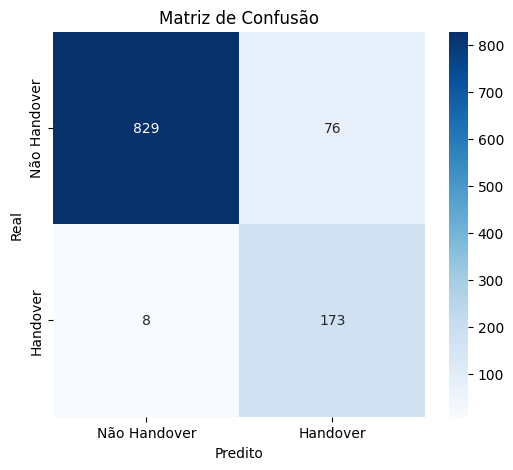

In [100]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Handover', 'Handover'], yticklabels=['Não Handover', 'Handover'])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

### 6.3: Curva Precision-Recall e ROC

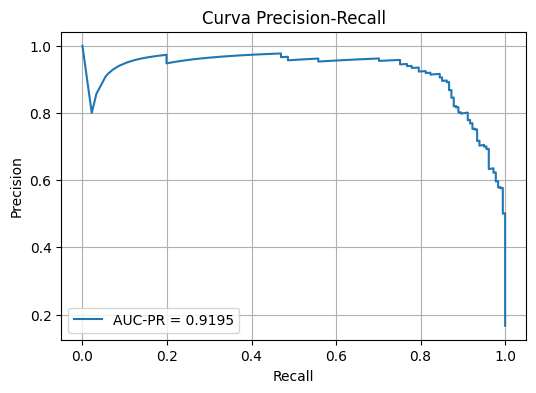

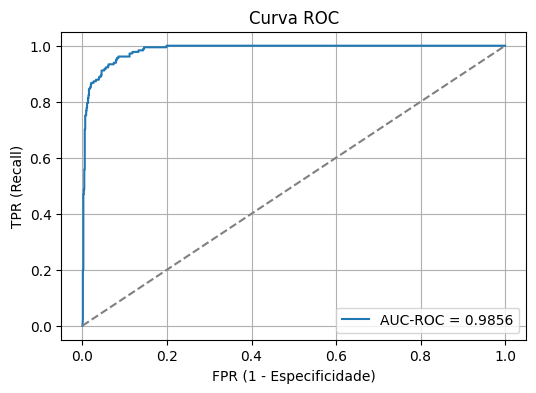

In [102]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# AUC-PR
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
auc_pr = auc(recall, precision)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend()
plt.grid(True)
plt.show()

# AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
auc_roc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC-ROC = {auc_roc:.4f}")
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("FPR (1 - Especificidade)")
plt.ylabel("TPR (Recall)")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()

### 6.4: Análises por cenários

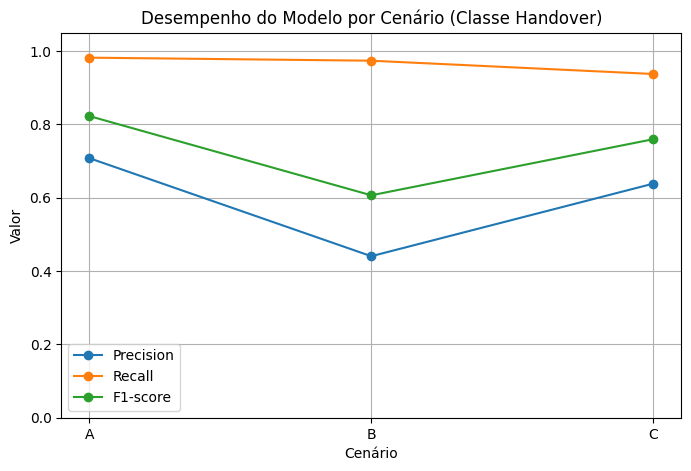

In [119]:
import matplotlib.pyplot as plt

cenarios = ['A', 'B', 'C']
precisao = [0.7078, 0.4405, 0.6383]
revocacao = [0.9820, 0.9737, 0.9375]
f1 = [0.8226, 0.6066, 0.7595]

x = range(len(cenarios))

plt.figure(figsize=(8,5))
plt.plot(x, precisao, label='Precision', marker='o')
plt.plot(x, revocacao, label='Recall', marker='o')
plt.plot(x, f1, label='F1-score', marker='o')

plt.xticks(x, cenarios)
plt.ylim(0,1.05)
plt.title("Desempenho do Modelo por Cenário (Classe Handover)")
plt.ylabel("Valor")
plt.xlabel("Cenário")
plt.grid(True)
plt.legend()
plt.show()

In [120]:
import numpy as np
from sklearn.metrics import confusion_matrix

# 1. Previsões finais (assegurando que seja binário)
y_pred_prob = model.predict(X_test).flatten()
threshold = 0.2  # ou o que você usou
y_pred = (y_pred_prob >= threshold).astype(int)

# 2. Obter rótulo de erro: VP, VN, FP, FN
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(cm)

# 3. Categorizar as predições
error_types = []

for true, pred in zip(y_test, y_pred):
    if true == 1 and pred == 1:
        error_types.append("TP")
    elif true == 0 and pred == 0:
        error_types.append("TN")
    elif true == 0 and pred == 1:
        error_types.append("FP")
    elif true == 1 and pred == 0:
        error_types.append("FN")

error_types = np.array(error_types)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Matriz de Confusão:
[[796 109]
 [  5 176]]


In [122]:
# Selecionar apenas a última linha de cada janela para associar com uma amostra
X_test_last = X_test[:, -1, :]  # shape: (n_amostras, n_features)

# Vamos supor que você tenha salvo a lista dos cenários:
# scenarios_test = [...]  (ordenado como y_test)

# Converter para DataFrame para análise
import pandas as pd

df_test = pd.DataFrame(X_test_last, columns=features)
df_test["true"] = y_test
df_test["pred"] = y_pred
df_test["erro"] = error_types
df_test["scenario"] = sc_test[:len(df_test)]  # garantir o shape

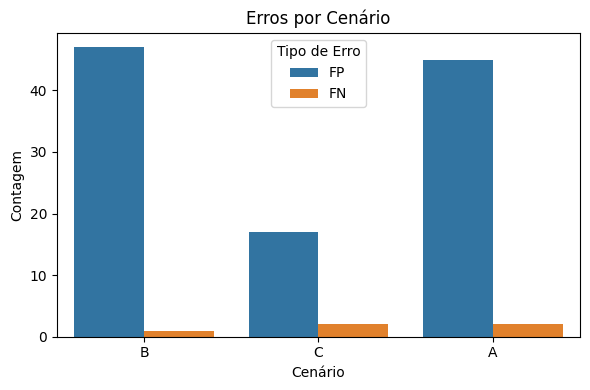

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=df_test[df_test["erro"].isin(["FP", "FN"])], x="scenario", hue="erro")
plt.title("Erros por Cenário")
plt.xlabel("Cenário")
plt.ylabel("Contagem")
plt.legend(title="Tipo de Erro")
plt.tight_layout()
plt.show()

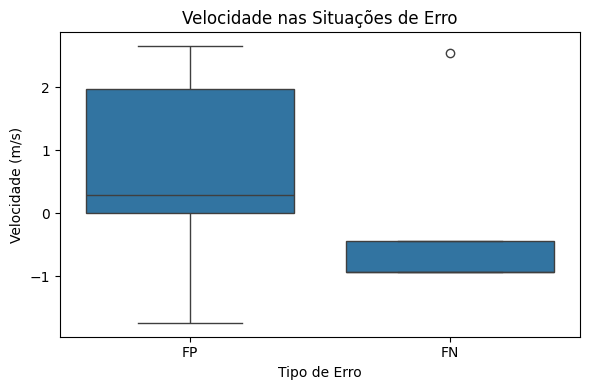

In [124]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df_test[df_test["erro"].isin(["FP", "FN"])], x="erro", y="speed")
plt.title("Velocidade nas Situações de Erro")
plt.xlabel("Tipo de Erro")
plt.ylabel("Velocidade (m/s)")
plt.tight_layout()
plt.show()

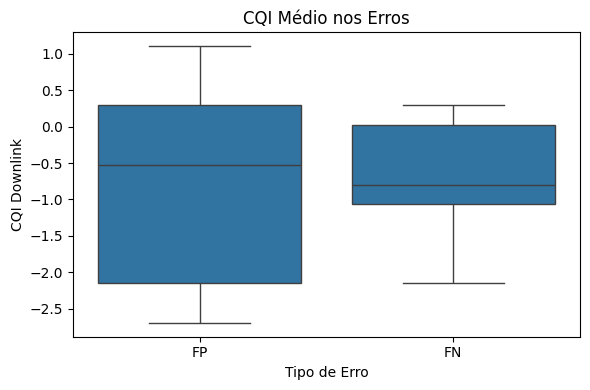

In [125]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df_test[df_test["erro"].isin(["FP", "FN"])], x="erro", y="average_cqi_dl")
plt.title("CQI Médio nos Erros")
plt.xlabel("Tipo de Erro")
plt.ylabel("CQI Downlink")
plt.tight_layout()
plt.show()

## ETAPA 7 — Avaliação da Rede

In [142]:
import numpy as np

# - df: DataFrame original completo
# - y_pred: previsões do modelo (probabilidades ou binárias)
# - WINDOW_SIZE: tamanho da janela
# - indices_test: índices no df onde cada janela de teste começou

# Passo 1: Iniciar coluna
df_pred = df.copy()
df_pred['handover_pred'] = 0

# Passo 2: Se for probabilidade, aplicar limiar (ajustável)
threshold = 0.5  # ou outro valor escolhido
y_pred_bin = (y_pred >= threshold).astype(int)

# Passo 3: Identificar linhas correspondentes a cada janela de teste
# → Cada X_test[i] representa janelas com índice_base + i
# → Portanto, a linha final da janela está em: índice_base[i] + WINDOW_SIZE

# Você precisa fornecer o array de índices de onde cada janela testada veio
# Ex: indices_test = [1203, 1204, 1205, ...]
# Se não tiver isso salvo, podemos tentar reconstruir.

for i, pred in enumerate(y_pred_bin):
    if pred == 1:
        idx_final = indices_test[i] + WINDOW_SIZE
        if idx_final < len(df_pred):
            df_pred.at[idx_final, 'handover_pred'] = 1

In [148]:
def count_matches_with_tolerance(real_idx, pred_idx, tolerance=10):
    matches = 0
    real_set = set(real_idx)
    pred_set = set(pred_idx)

    for r in real_set:
        if any(abs(r - p) <= tolerance for p in pred_set):
            matches += 1
    return matches

In [149]:
handover_real_idx = df_pred.index[df_pred['handover'] == 1].tolist()
handover_pred_idx = df_pred.index[df_pred['handover_pred'] == 1].tolist()

In [151]:
match_count = count_matches_with_tolerance(handover_real_idx, handover_pred_idx, tolerance=5)
print(f"✔️ Acertos com tolerância de ±10 linhas: {match_count}/{len(handover_real_idx)}")

✔️ Acertos com tolerância de ±10 linhas: 65/125


In [156]:
def get_metric_around(df, column, idx, window=5):
    """
    Retorna a média antes e depois de um índice para uma métrica.
    """
    before = df[column].iloc[max(idx - window, 0):idx].mean()
    after = df[column].iloc[idx + 1:min(idx + 1 + window, len(df))].mean()
    return before, after

# Índices dos eventos
handover_real_idx = df_pred.index[df_pred['handover'] == 1].tolist()
handover_pred_idx = df_pred.index[df_pred['handover_pred'] == 1].tolist()

# Avaliar impacto
metricas = ['mac_delay_ul', 'mac_delay_dl', 'throughput', 'average_cqi_dl']
resultados = []

for tipo, indices in [('Real', handover_real_idx), ('Previsto', handover_pred_idx)]:
    for metrica in metricas:
        befores = []
        afters = []
        for idx in indices:
            b, a = get_metric_around(df_pred, metrica, idx, window=5)
            befores.append(b)
            afters.append(a)
        resultados.append({
            'tipo': tipo,
            'métrica': metrica,
            'média_antes': np.mean(befores),
            'média_depois': np.mean(afters),
            'diferença': np.mean(afters) - np.mean(befores)
        })

df_result = pd.DataFrame(resultados)
print(df_result)

       tipo         métrica  média_antes  média_depois  diferença
0      Real    mac_delay_ul     0.001139      0.001238   0.000099
1      Real    mac_delay_dl     0.001139      0.001238   0.000099
2      Real      throughput   341.909158    259.744924 -82.164234
3      Real  average_cqi_dl     9.731200      9.936000   0.204800
4  Previsto    mac_delay_ul     0.001158      0.001320   0.000162
5  Previsto    mac_delay_dl     0.001158      0.001320   0.000162
6  Previsto      throughput   236.102898    250.828526  14.725627
7  Previsto  average_cqi_dl     9.308070      9.408421   0.100351


In [157]:
# Criar lista com dados formatados
dados_boxplot = []

for tipo, indices in [('Real', handover_real_idx), ('Previsto', handover_pred_idx)]:
    for metrica in metricas:
        for idx in indices:
            b, a = get_metric_around(df_pred, metrica, idx, window=5)
            dados_boxplot.append({'tipo': tipo, 'quando': 'Antes', 'métrica': metrica, 'valor': b})
            dados_boxplot.append({'tipo': tipo, 'quando': 'Depois', 'métrica': metrica, 'valor': a})

df_boxplot = pd.DataFrame(dados_boxplot)

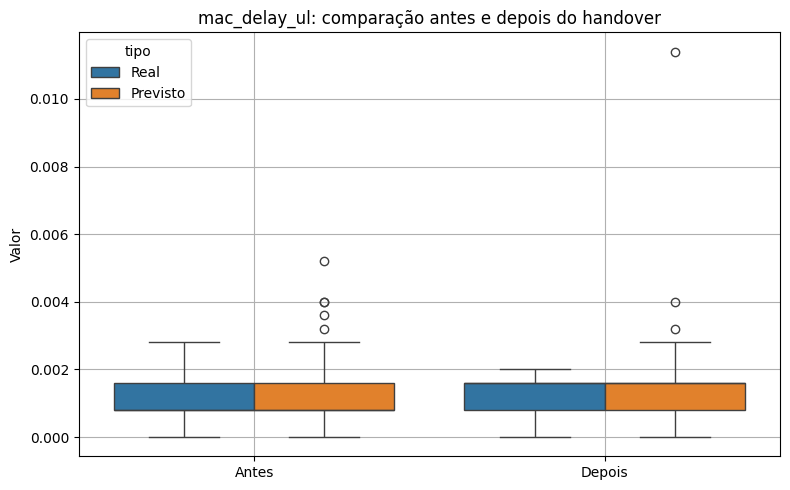

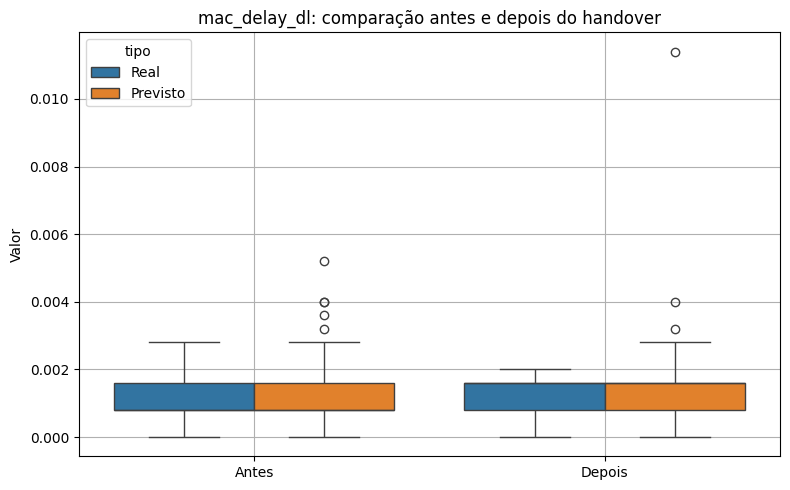

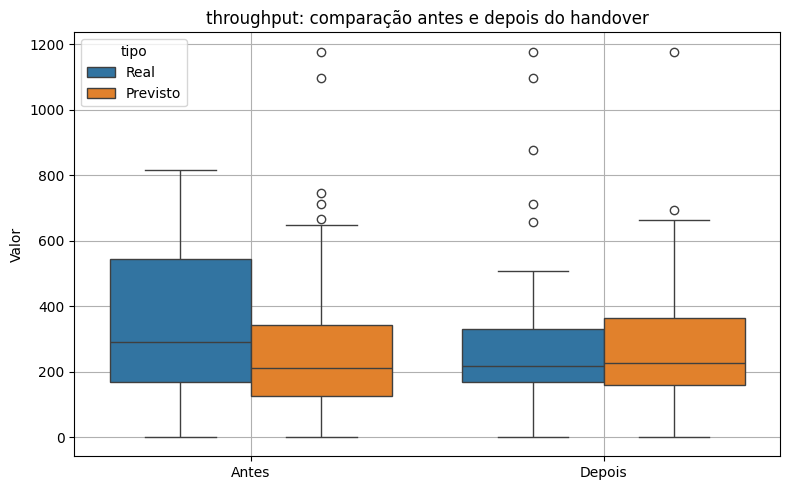

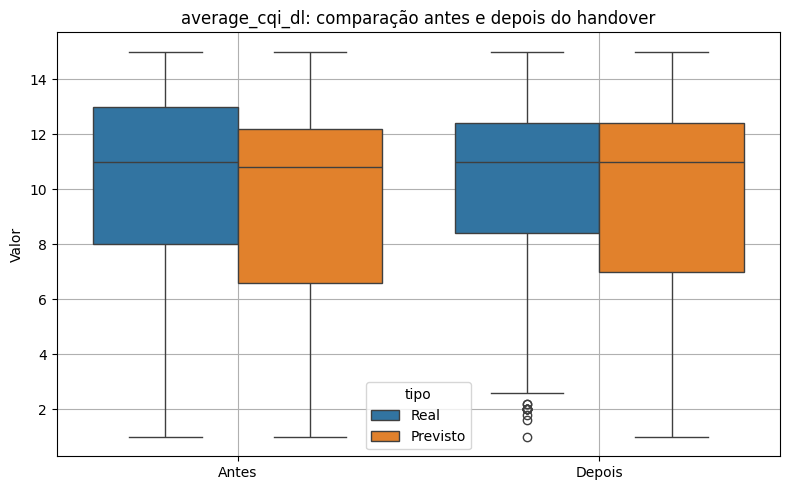

In [158]:
for metrica in metricas:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_boxplot[df_boxplot['métrica'] == metrica],
                x='quando', y='valor', hue='tipo')
    plt.title(f'{metrica}: comparação antes e depois do handover')
    plt.ylabel('Valor')
    plt.xlabel('')
    plt.grid(True)
    plt.tight_layout()
    plt.show()